# 라이브러리

In [ ]:
# 파이썬 표준 라이브러리
import gc
import random

# 파이썬 서드파티 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# 파이썬 버전
!python --version
# -> 3.10.12

Python 3.10.12


In [ ]:
# 라이브러리 버전
# numpy==1.26.4
# pandas==2.2.2
# matplotlib==3.8.0
# torch==2.5.1+cu121
# huggingface_hub==0.26.2
# transformers==4.46.2

# 클래스

## 인코더 데이터셋 클래스

In [ ]:
# 인코더 데이터셋 클래스
class EncodeDataset(Dataset):
    def __init__(self, encode_dataset, label):
        self.input_ids = encode_dataset['input_ids']
        self.attention_mask = encode_dataset['attention_mask']
        self.label = torch.from_numpy(label.to_numpy())

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.label[idx]

# 함수

## 데이터셋 전처리 함수

In [ ]:
# 데이터셋 전처리 함수
def preprocessing_data(data: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    """pandas DataFrame 형태의 데이터셋을 입력으로 받아서 학습 데이터셋으로 만드는 함수

    Args:
        data: 5개의 Column(title, text, subject, date, fake)으로 구성된 DataFrame

    Returns:
        X: 전처리 된 입력 데이터(pd.Series)
        y: 예측 레이블인 타깃 데이터(pd.Series)
        -> (X, y)
    """

    X = "<title>" + data['title'] + "<content>" +  data['text'] + "<end>"
    y = data['fake'].copy(deep=True)

    return X, y

## 레이블 예측 함수

In [ ]:
# 레이블 예측 함수
def predict(prob: torch.Tensor) -> torch.Tensor:
    """softmax로 계산된 확률을 바탕으로 최종 예측 레이블을 계산하는 함수

    사전학습 모델은 0이 가짜, 1이 진짜인 데이터로 학습된 모델
    주어진 데이터셋은 0이 진짜, 1이 가짜인 데이터셋이므로 보정 필요

    Args:
        softmax로 계산된 Tensor, shape: (batch_size, 2)

    Returns:
        최종 예측 레이블 Tensor, shape: (batch_size,)
    """

    return (prob.argmax(1) + 1) & 1

## 테스트셋 평가 함수

In [ ]:
# 테스트셋 평가 함수
def test(dataloader: DataLoader, model: nn.Module, device: str = 'cpu') -> tuple[dict[str, list[float]], list[int], float]:
    """모델의 성능을 평가하는 함수

    Args:
        dataloader: 데이터셋으로부터 만들어진 DataLoader
        model: 사전학습된 파이토치 모델
        device: cpu 또는 cuda

    Returns:
        prob_dict: 'Fake', 'Real'들의 확률들을 가진 딕셔너리
        result: 최종 예측 레이블 리스트
        acc: 최종 정확도
    """

    model.to(device)
    model.eval()
    softmax = nn.Softmax(dim=1)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct = 0
    cnt = 0
    prob_dict = {'Fake': [], 'Real': []}
    result = []

    with torch.no_grad():
        for idx, (input_ids, mask, label) in enumerate(dataloader, start=1):
            input_ids, mask, label = input_ids.to(device), mask.to(device), label.to(device)
            output = model(input_ids, attention_mask=mask)
            prob = softmax(output.logits)
            prob_dict['Fake'].extend(prob[:, 0].tolist())
            prob_dict['Real'].extend(prob[:, 1].tolist())
            pred = predict(prob=prob)
            result.extend(pred.tolist())
            cnt += len(label)
            correct += (pred == label).type(torch.int).sum().item()
            print(f"{idx}번째 배치 종료")
            print(f"현재까지 정답 갯수: {correct}, 오답 갯수: {cnt - correct}, 평가 갯수: {cnt}")
            print(f"현재까지 정확도: {correct / cnt}")
            print()

    acc = correct / size
    print('-' * 60)
    print()
    print(f"최종 정답 갯수: {correct}, 오답 갯수: {size - correct}, 평가 갯수: {size}")
    print(f"최종 정확도: {acc}")
    return prob_dict, result, acc

# 변수 및 설정

In [ ]:
# 하이퍼 파라미터
batch_size = 256
max_length = 512

# 재현성을 위한 시드 설정
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = 'cpu'

print(device)

cuda


# 데이터 불러오기

In [ ]:
# Title: 뉴스기사 제목
# Text: 뉴스기사 본문
# Subject: 뉴스기사 분류
# Date: 뉴스기사 게재일
# Fake: 가짜 뉴스 여부(0이면 진짜, 1은 가짜)
df = pd.read_csv('/content/drive/MyDrive/Practice/sb_data.csv')
df

,title,text,subject,date,fake
0,France invites U.S. to Dec. 13 summit on boost...,ACCRA (Reuters) - French President Emmanuel Ma...,worldnews,"November 30, 2017",0
1,Trump keeps politics on his Thanksgiving menu,"WEST PALM BEACH, Fla./WASHINGTON (Reuters) - U...",politicsNews,"November 24, 2016",0
2,Ireland's Fianna Fail party says will be elect...,DUBLIN (Reuters) - Ireland s second-largest pa...,worldnews,"November 24, 2017",0
3,REPUBLICAN LEADER Implies He May Not Seat Roy ...,The New York Times just confirmed what we ve a...,politics,"Nov 12, 2017",1
4,U.S. Senate approves Trump pick as top Fed reg...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"October 5, 2017",0
...,...,...,...,...,...
35913,Tennessee governor endorses Rubio in Republica...,WASHINGTON (Reuters) - Tennessee Governor Bill...,politicsNews,"February 25, 2016",0
35914,Republican Trump backed Iraq war in 2002 inter...,(Reuters) - Republican presidential front-runn...,politicsNews,"February 19, 2016",0
35915,Impact of firing Sessions could be troublesome...,(Reuters) - President Donald Trump could trigg...,politicsNews,"July 25, 2017",0
35916,U.S. hopes for more from Russia after Crimean ...,KIEV (Reuters) - The release of two Crimean Ta...,worldnews,"October 28, 2017",0


# 레이블 분포

In [ ]:
# 진짜 뉴스 및 가짜 뉴스의 갯수와 비율
(df['fake'].groupby(by=df['fake']).agg([('count', 'count'), ('ratio', lambda x: len(x) / len(df['fake']))])
            .sort_index().rename(index={0: 'Real', 1: 'Fake'}))

,count,ratio
fake,,
Real,17133,0.477003
Fake,18785,0.522997


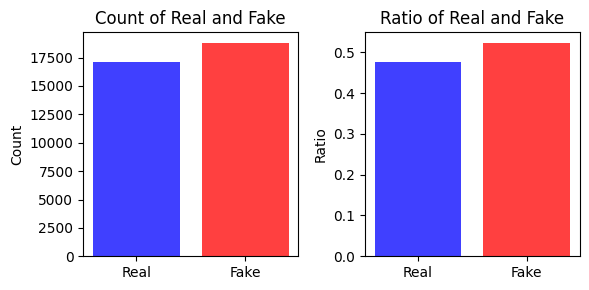

In [ ]:
# 진짜 뉴스 및 가짜 뉴스의 갯수와 비율 시각화
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

for idx, g in enumerate(('Count', 'Ratio')):
    x = ['Real', 'Fake']
    color = ['blue', 'red']
    alpha = 0.75
    if g == 'Count':
        y = df['fake'].value_counts().sort_index().values
    else:
        y = df['fake'].value_counts(normalize=True).sort_index().values

    axes[idx].bar(x, y, color=color, alpha=alpha)
    axes[idx].set_ylabel(f'{g}')
    axes[idx].set_title(f'{g} of Real and Fake')

plt.tight_layout()
plt.show()

# 전처리

In [ ]:
df['date'] = df['date'].str.strip()
# -> 이거 안해주면 결과가 올바르지 않음. 맨 앞/뒤에 공백, 탭 등이 있는 데이터가 존재하리라 추정

## 1. date Column

In [ ]:
df['date'].unique()
# -> 비정상적인 날짜 입력들이 있음

array(['November 30, 2017', 'November 24, 2016', 'November 24, 2017', ...,
       'Nov 10, 2015',
       'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/',
       'Sep 4, 2015'], dtype=object)

In [ ]:
# 가짜 뉴스 데이터들의 날짜 포맷
df.loc[df['fake'] == 1, 'date'].unique()

array(['Nov 12, 2017', 'Feb 23, 2016', 'January 8, 2016', ...,
       'October 9, 2017', 'November 15, 2017', 'Sep 4, 2015'],
      dtype=object)

In [ ]:
# 진짜 뉴스 데이터들의 날짜 포맷
df.loc[df['fake'] == 0, 'date'].unique()
# -> 진짜 뉴스 데이터들은 모두 '{풀네임 월} {일자}, {연도}' 형식으로 되어있음

array(['November 30, 2017', 'November 24, 2016', 'November 24, 2017',
       'October 5, 2017', 'July 25, 2016', 'October 19, 2017',
       'May 26, 2016', 'December 13, 2017', 'October 1, 2017',
       'November 10, 2017', 'February 10, 2016', 'November 22, 2016',
       'November 27, 2017', 'June 17, 2016', 'November 29, 2017',
       'November 2, 2017', 'December 25, 2017', 'April 13, 2017',
       'June 19, 2017', 'September 13, 2017', 'September 14, 2017',
       'September 18, 2017', 'April 9, 2016', 'September 12, 2017',
       'January 24, 2017', 'December 1, 2017', 'December 12, 2016',
       'April 5, 2017', 'April 8, 2016', 'May 9, 2017',
       'January 29, 2017', 'October 4, 2017', 'June 28, 2017',
       'November 19, 2017', 'September 6, 2016', 'December 18, 2017',
       'February 26, 2017', 'December 5, 2017', 'December 3, 2017',
       'January 14, 2016', 'June 26, 2017', 'June 13, 2016',
       'September 27, 2017', 'July 26, 2017', 'November 8, 2017',
       'Decemb

In [ ]:
# 진짜 뉴스의 날짜 데이터를 월명, 일자, 연도로 분리
real_date = df.loc[df['fake'] == 0, 'date'].str.split(r'[,\s]+', regex=True)
months, days, years = zip(*real_date.values)

In [ ]:
month_dict = {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5,
              'July': 6, 'August': 7, 'September': 8, 'October': 9, 'November': 10, 'December': 11}

months = np.unique(months).astype('object')
indices = np.argsort([month_dict[month] for month in months])
months[indices]
# -> 풀네임 월명은 1월부터 12월까지 모두 존재

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [ ]:
days = np.unique(days).astype('object')
indices = np.argsort([int(d) for d in days])
days[indices]
# -> 일자는 1일부터 31일까지 모두 존재

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype=object)

In [ ]:
years = np.unique(years).astype('object')
indices = np.argsort([int(y) for y in years])
years[indices]
# -> 연도는 2016 또는 2017이 존재

array(['2016', '2017'], dtype=object)

In [ ]:
# 풀네임 월명 패턴
months_ = ('January', 'February', 'March', 'April', 'May', 'June',
           'July', 'August', 'September', 'October', 'November', 'December')
month_pattern = '|'.join(months_)
# 일자 패턴
days_ = (str(i) for i in range(1, 31 + 1))
day_pattern = '|'.join(days_)
# 정상 날짜 데이터 패턴 확인
date_check = df['date'].str.contains(pat=rf'^(?:{month_pattern}) (?:{day_pattern}), \d{{4}}$')
date_check

,date
0,True
1,True
2,True
3,False
4,True
...,...
35913,True
35914,True
35915,True
35916,True


In [ ]:
df.loc[date_check, 'fake'].unique()
# -> date_check의 결과가 True인 값들은 가짜, 진짜가 혼합

array([0, 1])

In [ ]:
df.loc[~date_check, 'fake'].unique()
# -> date_check의 결과가 False인 값들은 모두 가짜 뉴스

array([1])

In [ ]:
# date_check의 결과가 0이면 올바른 날짜 데이터 포맷, 1이면 가짜 날짜 데이터 포맷
df['date_check'] = (~date_check).astype(int)
df

,title,text,subject,date,fake,date_check
0,France invites U.S. to Dec. 13 summit on boost...,ACCRA (Reuters) - French President Emmanuel Ma...,worldnews,"November 30, 2017",0,0
1,Trump keeps politics on his Thanksgiving menu,"WEST PALM BEACH, Fla./WASHINGTON (Reuters) - U...",politicsNews,"November 24, 2016",0,0
2,Ireland's Fianna Fail party says will be elect...,DUBLIN (Reuters) - Ireland s second-largest pa...,worldnews,"November 24, 2017",0,0
3,REPUBLICAN LEADER Implies He May Not Seat Roy ...,The New York Times just confirmed what we ve a...,politics,"Nov 12, 2017",1,1
4,U.S. Senate approves Trump pick as top Fed reg...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"October 5, 2017",0,0
...,...,...,...,...,...,...
35913,Tennessee governor endorses Rubio in Republica...,WASHINGTON (Reuters) - Tennessee Governor Bill...,politicsNews,"February 25, 2016",0,0
35914,Republican Trump backed Iraq war in 2002 inter...,(Reuters) - Republican presidential front-runn...,politicsNews,"February 19, 2016",0,0
35915,Impact of firing Sessions could be troublesome...,(Reuters) - President Donald Trump could trigg...,politicsNews,"July 25, 2017",0,0
35916,U.S. hopes for more from Russia after Crimean ...,KIEV (Reuters) - The release of two Crimean Ta...,worldnews,"October 28, 2017",0,0


## subject Column

In [ ]:
# 뉴스기사 분류 확인
df['subject'].unique()

array(['worldnews', 'politicsNews', 'politics', 'News', 'US_News',
       'left-news', 'Government News', 'Middle-east'], dtype=object)

In [ ]:
df.loc[df['fake'] == 1, 'subject'].unique()
# -> 가짜 뉴스들은 'politics', 'News', 'US_News', 'left-news', 'Government News', 'Middle-east'

array(['politics', 'News', 'US_News', 'left-news', 'Government News',
       'Middle-east'], dtype=object)

In [ ]:
df.loc[df['fake'] == 0, 'subject'].unique()
# -> 진짜 뉴스들은 'worldnews', 'politicsNews'

array(['worldnews', 'politicsNews'], dtype=object)

In [ ]:
# 이 데이터에서는 subject Column만으로도 가짜, 진짜 뉴스 여부를 판별할 수 있으나, 테스트 데이터에서는 섞여 있을 수 있음
# 따라서 이 Column을 포함할 경우, 제대로 된 학습을 기대하기 어려움

# 사전학습 모델

In [ ]:
# Hugging Face Token: -비밀-
# 1. Colab 왼쪽 패널에서 열쇠 모양의 "보안 비밀" 탭을 클릭
# 2. "새 보안 비밀 추가" 버튼을 클릭하고 "이름"에는 "HF_TOKEN", "값"에는 Token을 입력

In [ ]:
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
if hf_token:
    login(hf_token)
else:
    print("HF_TOKEN이 설정되지 않았습니다. Colab Secrets에 추가하세요.")

In [ ]:
# 사전학습 모델은 0이면 가짜, 1이면 진짜인 레이블로 학습
tokenizer = AutoTokenizer.from_pretrained("hamzab/roberta-fake-news-classification")
model = AutoModelForSequenceClassification.from_pretrained("hamzab/roberta-fake-news-classification")

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Practice/sb_data.csv')
X, y = preprocessing_data(data=df)

In [ ]:
encode = tokenizer(X.to_list(), max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
max_ratio = (encode['attention_mask'].sum(dim=1) == max_length).sum().item() / len(df)
print(f"토큰 수열 길이가 최댓값 {max_length}인 데이터의 비율: {max_ratio}")

토큰 수열 길이가 최댓값 512인 데이터의 비율: 0.4531154295896208


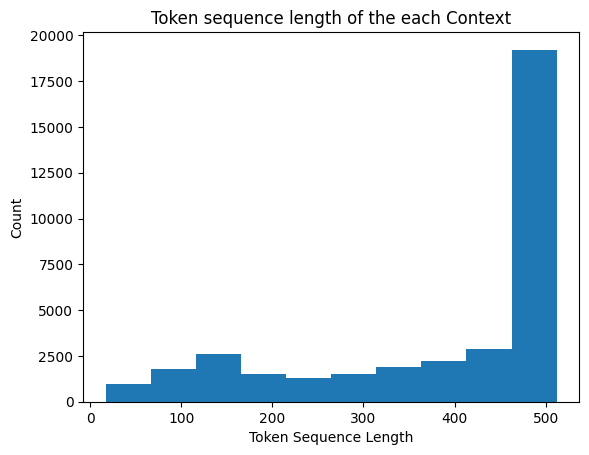

In [ ]:
plt.hist(encode['attention_mask'].sum(dim=1))
plt.xlabel('Token Sequence Length')
plt.ylabel('Count')
plt.title('Token sequence length of the each Context')
plt.show()
# -> 최대 45.3115%의 데이터들이 최대 토큰 수열 길이인 512에 잘려서 정보 손실이 발생

In [ ]:
dataset = EncodeDataset(encode_dataset=encode, label=y)

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 더 이상 사용하지 않는 객체 참조 해제
del df, X, y
del real_date, month_dict, months, days, years, indices
del months_, month_pattern, days_, day_pattern, date_check
del hf_token, encode, max_ratio
del fig, axes, idx, g, x, color, alpha

gc.collect()

4086

In [ ]:
_ = test(dataloader=dataloader, model=model, device=device)

1번째 배치 종료
현재까지 정답 갯수: 256, 오답 갯수: 0, 평가 갯수: 256
현재까지 정확도: 1.0

2번째 배치 종료
현재까지 정답 갯수: 511, 오답 갯수: 1, 평가 갯수: 512
현재까지 정확도: 0.998046875

3번째 배치 종료
현재까지 정답 갯수: 767, 오답 갯수: 1, 평가 갯수: 768
현재까지 정확도: 0.9986979166666666

4번째 배치 종료
현재까지 정답 갯수: 1023, 오답 갯수: 1, 평가 갯수: 1024
현재까지 정확도: 0.9990234375

5번째 배치 종료
현재까지 정답 갯수: 1279, 오답 갯수: 1, 평가 갯수: 1280
현재까지 정확도: 0.99921875

6번째 배치 종료
현재까지 정답 갯수: 1535, 오답 갯수: 1, 평가 갯수: 1536
현재까지 정확도: 0.9993489583333334

7번째 배치 종료
현재까지 정답 갯수: 1791, 오답 갯수: 1, 평가 갯수: 1792
현재까지 정확도: 0.9994419642857143

8번째 배치 종료
현재까지 정답 갯수: 2047, 오답 갯수: 1, 평가 갯수: 2048
현재까지 정확도: 0.99951171875

9번째 배치 종료
현재까지 정답 갯수: 2303, 오답 갯수: 1, 평가 갯수: 2304
현재까지 정확도: 0.9995659722222222

10번째 배치 종료
현재까지 정답 갯수: 2559, 오답 갯수: 1, 평가 갯수: 2560
현재까지 정확도: 0.999609375

11번째 배치 종료
현재까지 정답 갯수: 2815, 오답 갯수: 1, 평가 갯수: 2816
현재까지 정확도: 0.9996448863636364

12번째 배치 종료
현재까지 정답 갯수: 3071, 오답 갯수: 1, 평가 갯수: 3072
현재까지 정확도: 0.9996744791666666

13번째 배치 종료
현재까지 정답 갯수: 3327, 오답 갯수: 1, 평가 갯수: 3328
현재까지 정확도: 0.9996995192307693

14번째 배치 종료

# 테스트

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Practice/sb_validation.csv')

In [ ]:
X_test, y_test = preprocessing_data(data=df_test)

In [ ]:
test_encode = tokenizer(X_test.to_list(), max_length=512, padding="max_length", truncation=True, return_tensors="pt")

In [ ]:
test_dataset = EncodeDataset(encode_dataset=test_encode, label=y_test)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_prob_dict, test_result, test_acc = test(dataloader=test_dataloader, model=model, device=device)

1번째 배치 종료
현재까지 정답 갯수: 256, 오답 갯수: 0, 평가 갯수: 256
현재까지 정확도: 1.0

2번째 배치 종료
현재까지 정답 갯수: 512, 오답 갯수: 0, 평가 갯수: 512
현재까지 정확도: 1.0

3번째 배치 종료
현재까지 정답 갯수: 767, 오답 갯수: 1, 평가 갯수: 768
현재까지 정확도: 0.9986979166666666

4번째 배치 종료
현재까지 정답 갯수: 1023, 오답 갯수: 1, 평가 갯수: 1024
현재까지 정확도: 0.9990234375

5번째 배치 종료
현재까지 정답 갯수: 1279, 오답 갯수: 1, 평가 갯수: 1280
현재까지 정확도: 0.99921875

6번째 배치 종료
현재까지 정답 갯수: 1535, 오답 갯수: 1, 평가 갯수: 1536
현재까지 정확도: 0.9993489583333334

7번째 배치 종료
현재까지 정답 갯수: 1791, 오답 갯수: 1, 평가 갯수: 1792
현재까지 정확도: 0.9994419642857143

8번째 배치 종료
현재까지 정답 갯수: 2047, 오답 갯수: 1, 평가 갯수: 2048
현재까지 정확도: 0.99951171875

9번째 배치 종료
현재까지 정답 갯수: 2303, 오답 갯수: 1, 평가 갯수: 2304
현재까지 정확도: 0.9995659722222222

10번째 배치 종료
현재까지 정답 갯수: 2559, 오답 갯수: 1, 평가 갯수: 2560
현재까지 정확도: 0.999609375

11번째 배치 종료
현재까지 정답 갯수: 2815, 오답 갯수: 1, 평가 갯수: 2816
현재까지 정확도: 0.9996448863636364

12번째 배치 종료
현재까지 정답 갯수: 3071, 오답 갯수: 1, 평가 갯수: 3072
현재까지 정확도: 0.9996744791666666

13번째 배치 종료
현재까지 정답 갯수: 3327, 오답 갯수: 1, 평가 갯수: 3328
현재까지 정확도: 0.9996995192307693

14번째 배치 종료
현재까지 정답

## 결과 확인

In [ ]:
# 유일하게 틀린 값의 데이터 확인
wrong_answer = df_test[np.array(test_result) != y_test]
wrong_answer

,title,text,subject,date,fake
611,Northern Ireland: Life inside The Fountain,"LONDONDERRY, Northern Ireland (Reuters) - Will...",worldnews,"October 5, 2017",0


In [ ]:
fake_prob = test_prob_dict['Fake'][wrong_answer.index[0]]
real_prob = test_prob_dict['Real'][wrong_answer.index[0]]

print(f"Fake로 판단한 확률: {fake_prob}, Real로 판단한 확률: {real_prob}")

Fake로 판단한 확률: 0.8933478593826294, Real로 판단한 확률: 0.1066521629691124


In [ ]:
print("Title of Wrong Answer")
print('-' * 50)
print(wrong_answer['title'].values[0])

Title of Wrong Answer
--------------------------------------------------
Northern Ireland: Life inside The Fountain


In [ ]:
print("Text of Wrong Answer")
print('-' * 50)
wrong_answer['text'].values[0]

Text of Wrong Answer
--------------------------------------------------


'LONDONDERRY, Northern Ireland (Reuters) - William Jackson remembers the exodus vividly, when over 10,000 Protestants fled the west bank of Londonderry s River Foyle for the city s suburbs as Northern Ireland s  Troubles  erupted.  Almost 50 years on Jackson is among some 250 Protestants who stayed and carved out a tiny enclave known as  The Fountain , a tight, fiercely pro-British community that is separated by high walls and fences from the surrounding Irish nationalist heartland.  You are not talking one or two families, you are talking hundreds and hundreds and hundreds,  Jackson said, recalling the flight which began in 1969 when British troops were sent to the city to quell unrest over a civil rights campaign launched by the Catholic minority. Three decades of bloodshed followed between Catholic Irish nationalists, seeking to unite with Ireland, and pro-British Protestant loyalists, who want to remain part of the United Kingdom. Around 3,600 people were killed before a 1998 peace